In [2]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import *
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/Users/treycole/Codes/WanPy/tutorials


Setting up `pythTB` tight-binding model

In [26]:
delta = 1
t0 = 0.1
tprime = 0.5
n_super_cell = 2

model = models.chessboard(t0, tprime, delta).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern #: {chern: .1f}")
model.display()

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern #: -0.0
---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 2
r-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 8
number of electronic states = 8
lattice vectors:
 #  0  ===>  [     2.0 ,     0.0 ]
 #  1  ===>  [     0.0 ,     2.0 ]
positions of orbitals:
 #  0  ===>  [     0.0 ,     0.0 ]
 #  1  ===>  [    0.25 ,    0.25 ]
 #  2  ===>  [     0.0 ,     0.5 ]
 #  3  ===>  [    0.25 ,    0.75 ]
 #  4  ===>  [     0.5 ,     0.0 ]
 #  5  ===>  [    0.75 ,    0.25 ]
 #  6  ===>  [     0.5 ,     0.5 ]
 #  7  ===>  [    0.75 ,    0.75 ]
site energies:
 #  0  ===>      -1.0
 #  1  ===>       1.0
 #  2  ===>      -1.0
 #  3  ===>       1.0
 #  4  ===>      -1.0
 #  5  ===>       1.0
 #  6  ===>      -1.0
 #  7  ===>       1.0
hoppings:
<  0 | H |  4 + [  0 ,  0 ] >  

To store the eigenstates at their respective k-points, we will begin by initializing the `Bloch` class. This class is effectively a wrapper to the `pythTB` `wf_array` class with aditional methods useful for manipulating Bloch states. A `Bloch` object takes as its first argument a `pythTB` `model`, followed by the number of k-points along each reciprocal lattice basis vector.

In [30]:
nks = 20, 20
bloch = Bloch(model, nks[0], nks[1])

The `Bloch` object has as an attribute the `K_mesh`. This class stores the regular array of k-points in reduced units along which the Bloch states are defined. The class also contains methods that use the k-mesh when, for example, Wannierizing. To see the k-mesh points in reduced units, we will call `K_mesh.full_mesh`. The full mesh is a multidimensional array, with the number of axes depending on the dimensionality of reciprocal space. There is also a flat mesh which flattens the multiple dimensions into a single axis. 

In [31]:
full_mesh = bloch.K_mesh.full_mesh
flat_mesh = bloch.K_mesh.flat_mesh

print("Full k-mesh shape: ", full_mesh.shape)
print("Full k-mesh value at (3, 5): ", full_mesh[3, 5])
print("Full k-mesh value at the last point: ", full_mesh[-1, -1])
print()
print("Flat k-mesh shape: ", flat_mesh.shape)
print("Flat k-mesh value at 3*20+5 = (65): ", flat_mesh[65])
print("Flat k-mesh value at the last point: ", flat_mesh[-1])

Full k-mesh shape:  (20, 20, 2)
Full k-mesh value at (3, 5):  [0.15 0.25]
Full k-mesh value at the last point:  [0.95 0.95]

Flat k-mesh shape:  (400, 2)
Flat k-mesh value at 3*20+5 = (65):  [0.15 0.25]
Flat k-mesh value at the last point:  [0.95 0.95]


To initialize the Bloch energy eigenstates of the model as class attributes, we will call the `solve_model` method. This stores the eigenstates on a regular k-mesh excluding the endpoints. We can retrieve the eigenstates in either their cell-periodic ($u_{n, \mathbf{k}}$) or full Bloch ($\psi_{n, \mathbf{k}} = e^{i \mathbf{k} \cdot \mathbf{r}} u_{n, \mathbf{k}}$) form using the `get_energies` method. This returns a dictionary, with keys "Cell periodic" and "Bloch" whose values are the associated eigenstates.

In [42]:
bloch.solve_model()
eigstates = bloch.get_states()
u_nk = eigstates["Cell periodic"]
psi_nk = eigstates["Bloch"]

print("Shape of u_nk: ", u_nk.shape)
print("Shape of psi_nk: ", psi_nk.shape)
print("Value of u_nk with n = 0 and k = (0,0): ", "\n", u_nk[0,0,0,:].round(5))
print("Value of psi_nk with n = 0 and k = (0,0): ", "\n", psi_nk[0,0,0,:].round(5))
print("Value of u_nk with n = 1 and k = (0.15, 0.25): ", "\n", u_nk[3,5,1,:].round(5))
print("Value of psi_nk with n = 1 and k = (0.15, 0.25): ", "\n", psi_nk[3,5,1,:].round(5))

Shape of u_nk:  (20, 20, 8, 8)
Shape of psi_nk:  (20, 20, 8, 8)
Value of u_nk with n = 0 and k = (0,0):  
 [ 0.62785+0.j       0.22893+0.0043j  -0.01176-0.0024j  -0.0043 -0.23069j
  0.01176+0.0024j   0.0043 +0.23069j -0.62785+0.j      -0.22893-0.0043j ]
Value of psi_nk with n = 0 and k = (0,0):  
 [ 0.62785+0.j       0.22893+0.0043j  -0.01176-0.0024j  -0.0043 -0.23069j
  0.01176+0.0024j   0.0043 +0.23069j -0.62785+0.j      -0.22893-0.0043j ]
Value of u_nk with n = 1 and k = (0.15, 0.25):  
 [ 0.44753+0.j       0.14129-0.17249j  0.44753-0.j       0.14129-0.17249j
 -0.44753-0.j      -0.14129+0.17249j -0.44753-0.j      -0.14129+0.17249j]
Value of psi_nk with n = 1 and k = (0.15, 0.25):  
 [ 0.44753+0.j       0.21569-0.0565j   0.31645+0.31645j  0.19247+0.11257j
 -0.39875-0.20317j -0.21784-0.04758j -0.13829-0.42563j -0.12039-0.18768j]


To plot the bands, we will choose a 1D path through the BZ and pass this to `plot_bands` class method. Optionally, we can label the nodes and choose two sublattices to color the bands according to the eigenstates' weight on each sublattice.

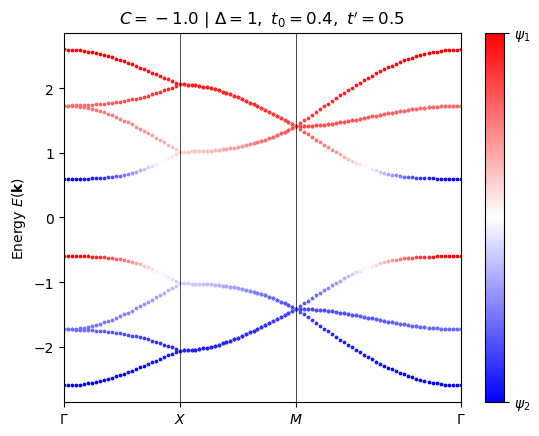

In [216]:
nk = 101
k_path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
k_label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
(k_vec, k_dist, k_node) = model.k_path(k_path, nk, report=False)

title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$")
fig, ax = eigstates.plot_bands(
    k_path=k_path, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)